# A02 treatment prediction
author:SheltonXiao

In [442]:
import pandas as pd
import numpy as np

import optuna

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LassoCV
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from ylearn.estimator_model import DML4CATE
from ylearn.estimator_model.effect_score import RLoss
from ylearn.estimator_model.doubly_robust import DoublyRobust

In [443]:
np.random.seed(233)

In [444]:
sW1C = ["V_"+str(each) for each in [5,19,24,14,15,2,36,31,28,39,10]]

In [445]:
def cal_nrmse(y_real,y_pred):
    return rmse(y_real,y_pred)/y_real.mean()

In [446]:
np.random.seed(233)

## Model 1

In [447]:
train = pd.read_csv('../data/processed/train_nnfilled3.csv',index_col = None)
test = pd.read_csv('../data/processed/test_nnfilled3.csv',index_col = None)

In [448]:
V_new = train[sW1C + ['treatment'] + ['outcome']]

In [449]:
colname = sW1C

In [450]:
dml1 = DML4CATE(cf_fold=3, x_model=RandomForestClassifier(n_estimators=250, criterion="entropy", max_depth=150, min_samples_leaf=2, min_samples_split=3, max_features=3,random_state=123),
               y_model=RandomForestRegressor(n_estimators=250, max_depth=150, min_samples_leaf=2, min_samples_split=2, max_features=3,random_state=123), 
               is_discrete_treatment=True,random_state=2022)
dml1.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname,)
ce_dml1 = dml1.effect_nji(data=V_new, control=0)
ce_dml_test1 = dml1.effect_nji(data=test[colname], control=0)
ce_dml_train1 = ce_dml1[:, :, 1:].reshape(-1, 2)
ce_dml_all1 = np.concatenate([ce_dml_train1, ce_dml_test1[:, :, 1:].reshape(-1, 2)], axis=0)

In [451]:
b = pd.read_csv("../output/result081702onlyfilldata082.csv",index_col = None)

In [452]:
cal_nrmse(b["ce_1"],ce_dml_all1[:,0])

0.06689989551887501

In [453]:
#ce_dml_all1 = b.values

## Model 2

In [454]:
train = pd.read_csv('../data/processed/train_nnfilled3.csv',index_col = None)
test = pd.read_csv('../data/processed/test_nnfilled3.csv',index_col = None)

In [455]:
V_new = train[sW1C + ['treatment'] + ['outcome']]

In [456]:
def onehot(V_new,test,col):
    enc = OneHotEncoder()
    enc.fit(V_new[[col]])
    new = enc.transform(V_new[[col]]).toarray()
    newtest = enc.transform(test[[col]]).toarray()
    for i in range(new.shape[1]):
        V_new[col+"_"+str(i)] = new[:,i]
        test[col+"_"+str(i)] = newtest[:,i]
    V_new = V_new.drop(columns = col)
    test = test.drop(columns = col)
    return V_new,test

In [457]:
#colname = [each for each in V_new.columns.tolist() if each not in ['treatment', 'outcome']]
colname = sW1C

In [458]:
dml2 = DML4CATE(cf_fold=3, x_model=RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=190, min_samples_leaf=19, min_samples_split=4, max_features=2,random_state=233),
               y_model=RandomForestRegressor(n_estimators=300, max_depth=80, min_samples_leaf=15, min_samples_split=4, max_features=3,random_state=233), 
               is_discrete_treatment=True,random_state=2022)
dml2.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname,)
ce_dml2 = dml2.effect_nji(data=V_new, control=0)
ce_dml_test2 = dml2.effect_nji(data=test[colname], control=0)
ce_dml_train2 = ce_dml2[:, :, 1:].reshape(-1, 2)
ce_dml_all2 = np.concatenate([ce_dml_train2, ce_dml_test2[:, :, 1:].reshape(-1, 2)], axis=0)

## Model 3

In [459]:
train = pd.read_csv('../data/processed/train_nnfilled3.csv',index_col = None)
test = pd.read_csv('../data/processed/test_nnfilled3.csv',index_col = None)

In [460]:
V_new = train[sW1C + ['treatment'] + ['outcome']]

In [461]:
colname = sW1C

In [462]:
dr1 = DoublyRobust(cf_fold=1, 
                  x_model=RandomForestClassifier(n_estimators=250, criterion="entropy", max_depth=150, 
                                                 min_samples_leaf=2, min_samples_split=3, max_features=3,random_state=233),
                  y_model = RandomForestRegressor(n_estimators=250, max_depth=150, min_samples_leaf=2, min_samples_split=2, max_features=3,random_state=233), 
                  yx_model = LinearRegression(), random_state=2022)
dr1.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname, treat = [1,2], control = 0)

DoublyRobust(x_model=RandomForestClassifier(criterion='entropy', max_depth=150, max_features=3,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=250, random_state=233), y_model=RandomForestRegressor(max_depth=150, max_features=3, min_samples_leaf=2,
                      n_estimators=250, random_state=233), yx_model=LinearRegression(), random_state=2022)

In [463]:
ce_dr1 = dr1.estimate(data=V_new, quantity=None,all_tr_effects = True)
ce_dr_test1 = dr1.estimate(data=test[sW1C], quantity=None,all_tr_effects = True)
ce_dr_train1 = ce_dr1[:, :, 1:].reshape(-1, 2)
ce_dr_all1 = np.concatenate([ce_dr_train1, ce_dr_test1[:, :, 1:].reshape(-1, 2)], axis=0)

## Model 4

In [464]:
train = pd.read_csv('../data/processed/train_nnfilled3.csv',index_col = None)
test = pd.read_csv('../data/processed/test_nnfilled3.csv',index_col = None)

In [465]:
V_new = train[sW1C + ['treatment'] + ['outcome']]

In [466]:
colname = sW1C

In [467]:
dml3 = DML4CATE(cf_fold=5, x_model=RandomForestClassifier(n_estimators=150, criterion="entropy", max_depth=110, min_samples_leaf=16, min_samples_split=10, max_features=2,random_state=233),
               y_model=RandomForestRegressor(n_estimators=200, max_depth=160, min_samples_leaf=8, min_samples_split=10, max_features=5,random_state=233), 
               is_discrete_treatment=True,random_state=2022)
dml3.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname,)
ce_dml3 = dml3.effect_nji(data=V_new, control=0)
ce_dml_test3 = dml3.effect_nji(data=test[colname], control=0)
ce_dml_train3 = ce_dml3[:, :, 1:].reshape(-1, 2)
ce_dml_all3 = np.concatenate([ce_dml_train3, ce_dml_test3[:, :, 1:].reshape(-1, 2)], axis=0)

## Model 5

考虑离群值和非离群值分开预测

In [468]:
train = pd.read_csv('../data/processed/train_cleaned.csv')
test = pd.read_csv('../data/processed/test_cleaned.csv')

In [469]:
trainlabel = pd.read_csv('../data/processed/train_label.csv')
testlabel = pd.read_csv('../data/processed/train_label2.csv')

In [470]:
V_new = train[sW1C + ['treatment'] + ['outcome']]

In [471]:
label1 = [not each for each in trainlabel.values]

In [472]:
V_new,test = onehot(V_new,test,"V_10")
V_new,test = onehot(V_new,test,"V_14")

C:\Users\Intel\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [473]:
colname = [each for each in V_new.columns.tolist() if each not in ['treatment', 'outcome']]

In [474]:
V_new2 = V_new[label1]

In [475]:
dml5 = DML4CATE(cf_fold=5, x_model=RandomForestClassifier(n_estimators=300, criterion="entropy", max_depth=90, min_samples_leaf=10, min_samples_split=7, max_features=2,random_state=123),
               y_model=RandomForestRegressor(n_estimators=100, max_depth=50, min_samples_leaf=16, min_samples_split=3, max_features=4,random_state=123), 
               is_discrete_treatment=True,random_state=2022)
dml5.fit(data=V_new2, outcome='outcome', treatment='treatment', covariate=colname,)
ce_dml5 = dml5.effect_nji(data=V_new, control=0)
ce_dml_test5 = dml5.effect_nji(data=test[colname], control=0)
ce_dml_train5 = ce_dml5[:, :, 1:].reshape(-1, 2)
ce_dml_all5 = np.concatenate([ce_dml_train5, ce_dml_test5[:, :, 1:].reshape(-1, 2)], axis=0)

## 模型融合

model1 2 3合力获取一个比较好的ce_1      
因为treatment1样本不均匀的现象比较严重

In [476]:
new_df = (pd.DataFrame(ce_dml_all2,columns = ["ce_1","ce_2"])*1.3 + pd.DataFrame(ce_dr_all1,columns = ["ce_1","ce_2"])*0.7)/2
conbime_df1 = (pd.DataFrame(ce_dml_all1,columns = ["ce_1","ce_2"]) + new_df)/2

model4 获取一个比较好的ce_2      
treatment2样本充足，用调参后的模型可以获取比较好的结果

In [477]:
conbime_df2 = conbime_df1[["ce_1"]]
conbime_df2["ce_2"] = ce_dml_all3[:,1]

array([[<AxesSubplot:title={'center':'ce_1'}>,
        <AxesSubplot:title={'center':'ce_2'}>]], dtype=object)

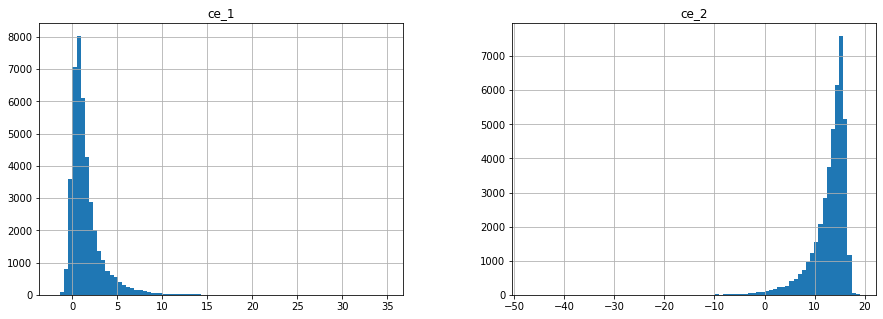

In [478]:
conbime_df2.hist(figsize = (15,5), bins = 80)

上述conbime_df2可以得到8月22日提交的0.7445的结果

In [479]:
#ce_dml_all_a = conbime_df2 
ce_dml_all_a = pd.read_csv("../output/result082205 5fold07445.csv",index_col = None)

In [480]:
cal_nrmse(ce_dml_all_a["ce_1"],conbime_df2["ce_1"])

0.023210326536931385

In [481]:
cal_nrmse(ce_dml_all_a["ce_2"],conbime_df2["ce_2"])

0.016269647825596065

再引入离群值分开预测的模型Model5进行融合

In [482]:
def conbime_mask(source_array,mask,mask_array):
    source_array[mask]  = mask_array[mask]
    return pd.DataFrame(source_array,columns = ["ce_1","ce_2"])

In [483]:
#ce_dml_all_a = conbime_df2 

In [484]:
totallabel = trainlabel.append(testlabel)
conbime_df3 = conbime_mask(ce_dml_all5,totallabel.iloc[:,0],ce_dml_all_a.values)

In [485]:
conbime_df4 = ((ce_dml_all_a*1.3 + conbime_df3*0.7)/2).copy()
conbime_df4["ce_2"] = ((ce_dml_all_a*0.25 + conbime_df3*1.75)/2)["ce_2"]

array([[<AxesSubplot:title={'center':'ce_1'}>,
        <AxesSubplot:title={'center':'ce_2'}>]], dtype=object)

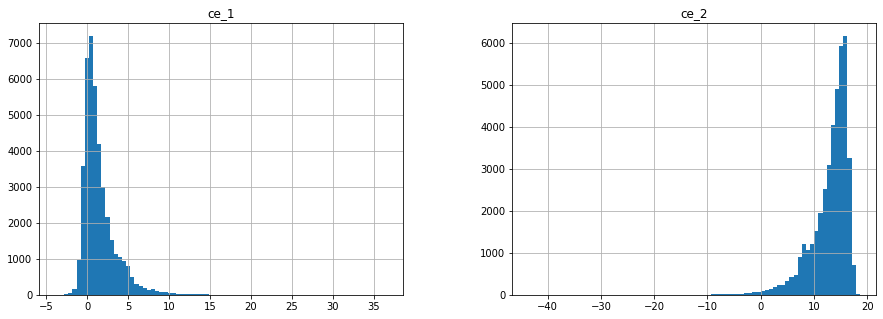

In [486]:
conbime_df4.hist(figsize = (15,5), bins = 80)

### 最后的结果

In [509]:
re = pd.read_csv("../output/result.csv",index_col = None)

In [518]:
cal_nrmse(re["ce_1"],conbime_df4["ce_1"])

0.057441950377301064

In [519]:
cal_nrmse(re["ce_2"],conbime_df4["ce_2"])

4.641958359532334e-19

In [490]:
#conbime_df4.to_csv("../output/result.csv",index = None)

## 原始提交文件

### Model 1 & 2 & 3的融合结果

In [495]:
#2 & 3
new_df = pd.read_csv("../output/result082004 137half08244.csv",index_col = None)

In [496]:
#1
ce_dml_all1 = pd.read_csv("../output/result081702onlyfilldata082.csv",index_col = None)

In [497]:
conbime_df1 = (ce_dml_all1 + new_df)/2

### 加上Model 4的融合结果

In [498]:
ce_dml_all_a = pd.read_csv("../output/result082205 5fold07445.csv",index_col = None)

### 加上Model 5的融合结果

In [515]:
ce_dml_all5 = pd.read_csv("../output/result082305 divide 5fold ce2 07394.csv",index_col = None)

In [516]:
totallabel = trainlabel.append(testlabel)
conbime_df3 = conbime_mask(ce_dml_all5.values,totallabel.iloc[:,0],ce_dml_all_a.values)

In [517]:
conbime_df4 = ((ce_dml_all_a*1.3 + conbime_df3*0.7)/2).copy()
conbime_df4["ce_2"] = ((ce_dml_all_a*0.25 + conbime_df3*1.75)/2)["ce_2"]

In [ ]:
#conbime_df4.to_csv("../output/result.csv",index = None)

## 其他代码

In [491]:
def cal_nrmse(y_real,y_pred):
    return rmse(y_real,y_pred)/y_real.mean()

### 参数优化

In [492]:
rloss = RLoss(x_model=RandomForestClassifier(),
               y_model=RandomForestRegressor(),
               cf_fold = 1,
               is_discrete_treatment=True,
               random_state=2022)
rloss.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname,)

RLoss

In [493]:
def create_model(trial):
    n_estimators1 = trial.suggest_int('n_estimators1', 2, 6)*50 #100
    #learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth1 = trial.suggest_int('max_depth1', 5, 20)*10#2,20
    min_samples_leaf1 = trial.suggest_int('min_samples_leaf1', 2, 20)#2,100,80
    min_samples_split1 = trial.suggest_int('min_samples_split1', 2, 10)
    max_features1 = trial.suggest_int('max_features1', 2, 5)

    n_estimators2 = trial.suggest_int('n_estimators2', 2, 6)*50 #100
    #learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth2 = trial.suggest_int('max_depth2', 5, 20)*10#2,20
    min_samples_leaf2 = trial.suggest_int('min_samples_leaf2', 2, 20)#2,100,80
    min_samples_split2 = trial.suggest_int('min_samples_split2', 2, 10)
    max_features2 = trial.suggest_int('max_features2', 2, 5)

    
    dml = DML4CATE(cf_fold=3, x_model=RandomForestClassifier(n_estimators=n_estimators1, criterion="entropy", max_depth=max_depth1, 
                                                            min_samples_leaf=min_samples_leaf1, min_samples_split=min_samples_split1, max_features=max_features1),
               y_model=RandomForestRegressor(n_estimators=n_estimators2, max_depth=max_depth2, min_samples_leaf=min_samples_leaf2, 
                                                min_samples_split=min_samples_split2, max_features=max_features2), 
               is_discrete_treatment=True,random_state=2022)
    return dml

def objective(trial):
    model = create_model(trial)
    model.fit(data=V_new, outcome='outcome', treatment='treatment', covariate=colname,)
    loss = rloss.score(model)[0]
    return loss